# Hyperparameter Optimization for fine-tuning pre-trained Transformer Models from HuggingFace

In this notebook, we will show how we can use Syne Tune to optimize the hyperparameters of pre-trained transformers
from Hugging Face when we fine tune them on NLP datasets from the GLUE benchmark suite.

## Setup

Install Syne Tune

In [5]:
!pip install 'syne-tune[extra]'

     |████████████████████████████████| 400 kB 6.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 48 kB 10.9 MB/s            
     |████████████████████████████████| 23.3 MB 52.4 MB/s            
     |████████████████████████████████| 100 kB 17.0 MB/s           
     |████████████████████████████████| 54.5 MB 118 kB/s             
     |████████████████████████████████| 1.6 MB 46.5 MB/s            
     |████████████████████████████████| 1.1 MB 58.7 MB/s            
     |████████████████████████████████| 4.1 MB 67.9 MB/s            
     |████████████████████████████████| 10.1 MB 41.2 MB/s            
     |████████████████████████████████| 125 kB 100.9 MB/s            
     |████████████████████████████████| 881.9 MB 6.9 kB/s              
     |████████████████████████████████| 64 kB 293 kB/s             
     |████████████████████████████████| 65 kB 455 kB/s             
  Preparing metadata (setup.py) ... done
     |█████████████

Install HuggingFace dependencies

In [2]:
!pip install 'torch==1.10.0' 'datasets==1.8.0' 'transformers'

     |████████████████████████████████| 881.9 MB 500 bytes/s           
     |████████████████████████████████| 237 kB 102.7 MB/s            
     |████████████████████████████████| 4.0 MB 104.0 MB/s            
     |████████████████████████████████| 20.7 MB 92.2 MB/s            
     |████████████████████████████████| 69 kB 460 kB/s             
     |████████████████████████████████| 211 kB 73.6 MB/s            
     |████████████████████████████████| 56 kB 367 kB/s             
     |████████████████████████████████| 3.8 MB 82.3 MB/s            
     |████████████████████████████████| 6.6 MB 98.5 MB/s            
     |████████████████████████████████| 3.5 MB 97.7 MB/s            
     |████████████████████████████████| 3.5 MB 58.3 MB/s            
     |████████████████████████████████| 3.5 MB 52.2 MB/s            
     |████████████████████████████████| 3.4 MB 79.1 MB/s            
     |████████████████████████████████| 3.3 MB 74.6 MB/s            
     |████████████████████████

In [23]:
import matplotlib as mpl #$; mpl.use('pgf')
import os

%matplotlib inline
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
from pathlib import Path

from syne_tune.backend.local_backend import LocalBackend
from syne_tune.tuner import Tuner
from syne_tune.search_space import uniform, loguniform, choice, randint
from syne_tune.stopping_criterion import StoppingCriterion
from syne_tune.optimizer.baselines import ASHA, MOBSTER, BayesianOptimization, RandomSearch, MOASHA
from syne_tune.constants import ST_WORKER_TIME
from syne_tune.backend.sagemaker_backend.instance_info import select_instance_type
from syne_tune.backend.sagemaker_backend.sagemaker_backend import SagemakerBackend
from syne_tune.backend.sagemaker_backend.sagemaker_utils import get_execution_role


TASK2METRICSMODE = {
    "cola": {'metric': 'matthews_correlation', 'mode': 'max'},
    "mnli": {'metric': 'accuracy', 'mode': 'max'},
    "mrpc": {'metric': 'f1', 'mode': 'max'},
    "qnli": {'metric': 'accuracy', 'mode': 'max'},
    "qqp": {'metric': 'f1', 'mode': 'max'},
    "rte": {'metric': 'accuracy', 'mode': 'max'},
    "sst2": {'metric': 'accuracy', 'mode': 'max'},
    "stsb": {'metric': 'spearmanr', 'mode': 'max'},
    "wnli": {'metric': 'accuracy', 'mode': 'max'},
}

## Optimizing Training Hyperparameters 

We start by optimizing hyperparameters that control the training process: learning rate, batch size and the ratio of training steps for warming up the learning rate, i.e where the learning rate is increased to its final value before we start decaying it back to 0.

We first need to define some additional parameters such as the dataset, the total number of runtime dedicated to the HPO process and the number of workers to distributed the evaluation of hyperparameters, etc. 
We set the number of workers equal to the number of GPUs, such that each GPU evaluates one configuration at a time.

In [10]:
dataset = 'mrpc'
max_runtime = 1800
num_train_epochs = 3 
n_workers = 1
seed = 12345
model_type = 'bert-base-cased'

For Syne Tune we need to define which metric we would like to optimize, and whether we maximize or minimize this metirc. Additionally, we also specify the resource attribute that determines how much resources we spend for the evaluation of a hyperparameter configuration, e.g the number of epochs for training.

In [12]:
metric = 'eval_' + TASK2METRICSMODE[dataset]['metric']
mode = TASK2METRICSMODE[dataset]['mode']
resource_attribute = 'epoch'

Next we define the path to the training scripts that gets the hyperparameters as input argument and reports the above define metrics back to Syne Tune. Here we use an adated version of the original Hugging Face script: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py

In [13]:
entry_point = "./run_glue.py"

The first configuration that we will always evaluate is the default configuration provided by Hugging Face. This makes sure that the configuration returned by Syne Tune performs at least as well as the default configuration.

In [14]:
default = {
    'learning_rate': 2e-5,
    'per_device_train_batch_size': 32,
    'warmup_ratio': 0.0,
}

Now we can define the configuration space, which contains the hyperparameters that we want to optimize plus all other parameters that we want to pass to the training script.

In [15]:
config_space = {
    'learning_rate': loguniform(1e-6, 1e-4),
    'per_device_train_batch_size': randint(16, 48),
    'warmup_ratio': uniform(0, 0.5),
    'num_train_epochs': num_train_epochs,
    'model_name_or_path': model_type,
    'task_name': dataset,
    'do_train': True,
    'max_seq_length': 128,
    'seed': seed,
    'output_dir': 'tmp/' + dataset,
    'evaluation_strategy': 'epoch', 
}

Before we can start the optimization process, we have to define the backend. Here we use the LocalBackend, which distributes the HPO process on the local machine. Later we will also see how we can parallelize the search across a set of SageMaker training jobs.

In [16]:
backend = LocalBackend(entry_point=entry_point)

We use ASHA (asynchronous successive halving) as HPO method, which samples configurations randomly and terminates poorly performing configurations early.

In [17]:
scheduler = ASHA(config_space, metric=metric,
                 resource_attr=resource_attribute, max_t=num_train_epochs,
                 mode=mode, random_seed=seed, points_to_evaluate=[default])

INFO:syne_tune.optimizer.schedulers.searchers.utils.default_arguments:scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'grace_period': Imputing default value 1
scheduler_options: Key 'reduction_factor': Imputing default value 3
scheduler_options: Key 'brackets': Imputing default value 1
scheduler_options: Key 'type': Imputing default value stopping
scheduler_options: Key 'searcher_data': Imputing default value rungs
scheduler_options: Key 'register_pending_myopic': Imputing default value False
scheduler_options: Key 'do_snapshots': Imputing default value False
scheduler_options: Key 'rung_system_per_bracket': Imputing default value True
scheduler_options: Key 'rung_system_kwargs': Imputing default value {'cost_attr': 'elapsed_time', 'ranking_criterion': 'soft_ranking', 'epsilon': 1.0, 'epsilon_scaling': 1.0}

INFO:syne_tune.optimizer.schedulers.fifo:Master random_seed = 12345


Now we have everything together to start the optimization process.

In [ ]:
stop_criterion = StoppingCriterion(max_wallclock_time=max_runtime)
tuner = Tuner(
    backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
)
tuner.run()

INFO:syne_tune.tuner:results of trials will be saved on /home/ec2-user/syne-tune/run-glue-2022-07-11-14-44-18-480
INFO:syne_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
learning_rate: 2e-05
per_device_train_batch_size: 32
warmup_ratio: 0.0
INFO:syne_tune.optimizer.schedulers.hyperband:trial_id 0 starts (first milestone = 1)
INFO:root:Detected 1 GPUs
INFO:root:running subprocess with command: /home/ec2-user/anaconda3/envs/python3/bin/python ./run_glue.py --learning_rate 2e-05 --per_device_train_batch_size 32 --warmup_ratio 0.0 --num_train_epochs 3 --model_name_or_path bert-base-cased --task_name mrpc --do_train True --max_seq_length 128 --seed 12345 --output_dir tmp/mrpc --evaluation_strategy epoch --st_checkpoint_dir /home/ec2-user/syne-tune/run-glue-2022-07-11-14-44-18-480/0/checkpoints
INFO:syne_tune.tuner:(trial 0) - scheduled config {'learning_rate': 2e-05, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'num_train_epochs': 3, 'model_name_or_path

Below we plot the test error of the best found model over time. As reference we plot the learning curve (red dots) of the default configuration, which, as explained above, is always evaluated first.
We can see that Syne Tune quickly finds a better performing configurations that improves upon the default configuration.

Text(0.5, 0, 'wall-clock time (seconds)')

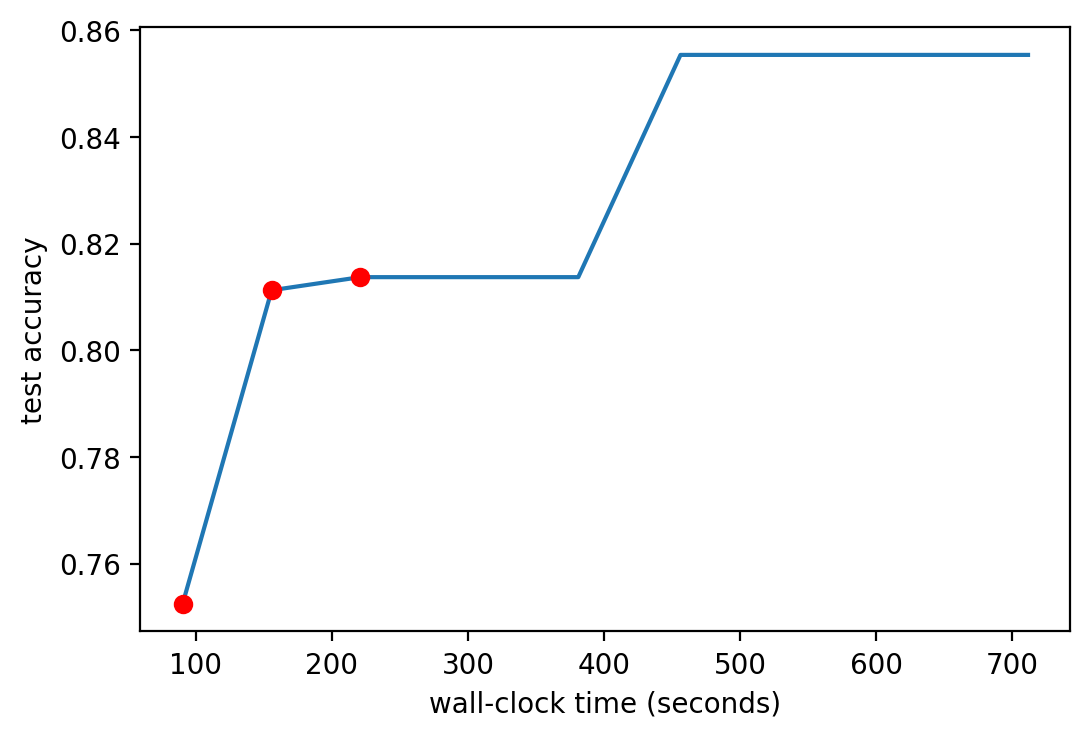

In [24]:
from syne_tune.experiments import load_experiment
exp = load_experiment(tuner.name)
df_hyperparameters = exp.results

plt.figure(dpi=200)

traj = df_hyperparameters['test_accuracy'].cummax()
runtime = df_hyperparameters['st_tuner_time']
plt.plot(runtime, traj)

df_default = df_hyperparameters[df_hyperparameters['trial_id'] == 0]
traj = df_default['test_accuracy'].cummax()
runtime = df_default['st_tuner_time']
plt.plot(runtime, traj, 'ro')

plt.ylabel('test accuracy')
plt.xlabel('wall-clock time (seconds)')

## Optimize the choice of the model

We extend the HPO such that it also automatically selected the right pre-trained model for us. We can achieve this by adding an additional categorical hyperparameter to our search space, that encodes the choice of the pre-trained model.

In [ ]:
config_space['model_name_or_path'] = choice(['bert-base-cased', 'bert-base-uncased', 'distilbert-base-uncased',
                                             'distilbert-base-cased', 'roberta-base',
                                             'albert-base-v2', 'distilroberta-base',
                                             'xlnet-base-cased', 'albert-base-v1',
                                             ])

default['model_name_or_path'] = 'bert-base-cased'

Now we run the search again under the same conditions as before.

In [ ]:
backend = LocalBackend(entry_point=entry_point)
scheduler = ASHA(config_space, metric=metric,
                 resource_attr=resource_attribute, max_t=num_train_epochs,
                 mode=mode, random_seed=seed, points_to_evaluate=[default])

stop_criterion = StoppingCriterion(max_wallclock_time=max_runtime)
tuner = Tuner(
    trial_backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
)
tuner.run()

After the search is finished, we compare the results to our previous results. We can see that optimizing in this augmented search space allows Syne Tune to find a much better performing hyperparameter configuration in the same amount of time.

In [ ]:
from syne_tune.experiments import load_experiment
exp_model_choice = load_experiment(tuner.name)
df_model_choice = exp_model_choice.results

plt.figure(dpi=200)


traj = df_hyperparameters['test_accuracy'].cummax()
runtime = df_hyperparameters['st_tuner_time']
plt.plot(runtime, traj, label='Hyperparameters not including model type')

traj = df_model_choice['test_accuracy'].cummax()
runtime = df_model_choice['st_tuner_time']
plt.plot(runtime, traj, label='Hyperparameters including model type')

df_default = df_model_choice[df_model_choice['trial_id'] == 0]
traj = df_default['test_accuracy'].cummax()
runtime = df_default['st_tuner_time']
plt.plot(runtime, traj, 'ro')

plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('wall-clock time (seconds)')

## Optimize the Instance Type

Last, we additionally automate the selection of the instance type for deploying the model later. While this will not affect predictive performance, the instance type influences the latency and the cost of training the model.
Thus, we do not optimize a single objective anymore but multiple objectives at the same time. The results is not a single configuration but a set of configuratios that optimially trade-off one metric vs the other.

The same as with the model choice, we will add an additional categorical hyperparameter that determines the instance type. For this example, we have to use the SageMaker backend of Syne Tune, which evaluates each hyperparameter configuration in a single SageMaker Training Job.

In [26]:
from sagemaker.huggingface import HuggingFace


instance_types = ['ml.g4dn.xlarge', 'ml.g4dn.2xlarge', 'ml.p2.xlarge', 'ml.g4dn.4xlarge',
                  'ml.g4dn.8xlarge', 'ml.p3.2xlarge']

config_space['st_instance_type'] = choice(instance_types)

backend = SagemakerBackend(
    sm_estimator=HuggingFace(
        entry_point=str('run_glue.py'),
        source_dir=os.getcwd(),
        base_job_name='glue-moasha',
        # instance-type given here are override by Syne Tune with values sampled from `st_instance_type`.
        instance_type='ml.m5.large',
        instance_count=1,
        py_version="py38",
        pytorch_version='1.9',
        transformers_version='4.12',
        max_run=3600,
        role=get_execution_role(),
    ),
)

INFO:syne_tune.backend.sagemaker_backend.sagemaker_utils:No Sagemaker role passed as environment variable $AWS_ROLE, inferring it.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Instead of single-objective ASHA, we now use MO-ASHA to optimize multiple objective simultaneously. 

In [28]:
from syne_tune.constants import ST_WORKER_COST

scheduler = MOASHA(
    max_t=num_train_epochs,
    time_attr=resource_attribute,
    metrics=[metric, 'latency', ST_WORKER_COST],
    mode=[mode, 'min', 'min'],
    config_space=config_space,
)
stop_criterion = StoppingCriterion(max_wallclock_time=10800)
tuner = Tuner(
    backend=backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=4,
)
tuner.run()

Below we plot the latency and cost of all configurations that we trained for the full amount of epochs. The color indicated the instance type. We also plot the Pareto front (dashed black line), i.e the set of configurations that dominate all other configurations in at least one objective and equally well in all other objectives.

In [29]:
import numpy as np

from syne_tune.constants import ST_WORKER_COST
from syne_tune.experiments import load_experiment


def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

exp = load_experiment(tuner.name)
df = exp.results
metric_name = 'test_accuracy'

df = df[df['epoch'] == 3]

markers = ['o', 'D', 's', 'x', 'p', 'h']

plt.figure(dpi=200)

x = df['latency']
y = 1 - df[metric_name]

data = np.array([x, y]).T
idx = is_pareto_efficient(data)
sort = np.argsort(data[idx, 0])
plt.step(data[idx, 0][sort], data[idx, 1][sort], linestyle='--', color='k', where='post')

for i, instance_type in enumerate(df.config_st_instance_type.unique()):
    sub_df = df[df['config_st_instance_type'] == instance_type]
    plot_label = True
    for j, model_type in enumerate(df.config_model_name_or_path.unique()):
        
        sub_sub_df = sub_df[sub_df['config_model_name_or_path'] == model_type]
        x = sub_sub_df['latency']
        y = 1 - sub_sub_df[metric_name]
        if plot_label:
            plt.scatter(x, y, color='C%d' % i, marker='o', label=instance_type)
            plot_label = False
        else:
            plt.scatter(x, y, color='C%d' % i, marker='o')

plt.ylabel('test error')
plt.xlabel('latency (milliseconds)')
plt.legend()
plt.show()


INFO:root:experiment run-glue-2022-07-11-14-57-20-136 not found locally, trying to get it from s3.
INFO:root:downloading metadata.json on s3://sagemaker-us-west-2-770209394645/syne-tune/run-glue-2022-07-11-14-57-20-136
INFO:root:could not find metadata.json on s3://sagemaker-us-west-2-770209394645/syne-tune/run-glue-2022-07-11-14-57-20-136
INFO:root:downloading results.csv.zip on s3://sagemaker-us-west-2-770209394645/syne-tune/run-glue-2022-07-11-14-57-20-136
INFO:root:could not find results.csv.zip on s3://sagemaker-us-west-2-770209394645/syne-tune/run-glue-2022-07-11-14-57-20-136
INFO:root:downloading tuner.dill on s3://sagemaker-us-west-2-770209394645/syne-tune/run-glue-2022-07-11-14-57-20-136
INFO:root:could not find tuner.dill on s3://sagemaker-us-west-2-770209394645/syne-tune/run-glue-2022-07-11-14-57-20-136


TypeError: 'NoneType' object is not subscriptable

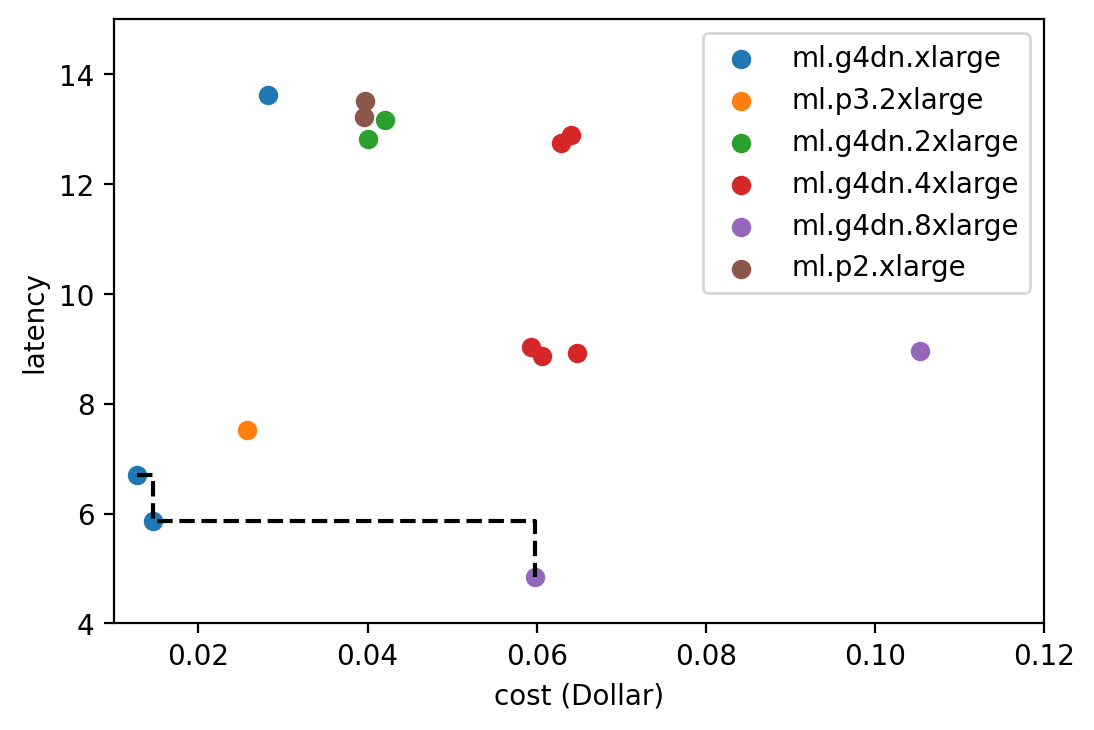

In [22]:
plt.figure(dpi=200)

x = df[ST_WORKER_COST]
y = df['latency']

data = np.array([x, y]).T
idx = is_pareto_efficient(data)
sort = np.argsort(data[idx, 0])
plt.step(data[idx, 0][sort], data[idx, 1][sort], linestyle='--', color='k', where='post')

for i, instance_type in enumerate(df.config_st_instance_type.unique()):
    sub_df = df[df['config_st_instance_type'] == instance_type]
    plot_label = True
    for j, model_type in enumerate(df.config_model_name_or_path.unique()):
        
        sub_sub_df = sub_df[sub_df['config_model_name_or_path'] == model_type]
        x = sub_sub_df[ST_WORKER_COST]
        y = sub_sub_df['latency']
        
        if plot_label:
            plt.scatter(x, y, color='C%d' % i, marker='o', label=instance_type)
            plot_label = False
        else:
            plt.scatter(x, y, color='C%d' % i, marker='o')

plt.ylabel('latency')
plt.xlabel('cost (Dollar)')
plt.legend()
plt.xlim(0.01, 0.12)
plt.ylim(4, 15)
plt.show()
